In [1]:
import sys
import os
import warnings
warnings.filterwarnings("ignore")
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import nltk

In [2]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_score,recall_score,f1_score
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import Pipeline
from sklearn.svm import LinearSVC
from sklearn.naive_bayes import MultinomialNB

In [3]:
import mlflow
import mlflow.sklearn
from mlflow.tracking import MlflowClient

In [4]:
mlflow.set_tracking_uri("http://localhost:5000")
mlflow.set_experiment("spam_ham")

2022/08/03 09:02:39 INFO mlflow.tracking.fluent: Experiment with name 'spam_ham' does not exist. Creating a new experiment.


<Experiment: artifact_location='./artifacts/5', experiment_id='5', lifecycle_stage='active', name='spam_ham', tags={}>

In [5]:
import re

In [6]:
# show seaborn

In [7]:
import seaborn as sns

In [8]:
def create_roc_auc_plot(clf, X_data, y_data):
    import matplotlib.pyplot as plt
    from sklearn import metrics
    metrics.plot_roc_curve(clf, X_data, y_data) 
    plt.savefig('roc_auc_curve.png')

In [9]:
def create_confusion_matrix_plot(clf, X_test, y_test):
    import matplotlib.pyplot as plt
    from sklearn.metrics import plot_confusion_matrix
    plot_confusion_matrix(clf, X_test, y_test)
    plt.savefig('confusion_matrix.png')

In [10]:
def get_metrics(y_true, y_pred):
    from sklearn.metrics import accuracy_score,precision_score,recall_score,log_loss
    acc = accuracy_score(y_true, y_pred)
    prec = precision_score(y_true, y_pred)
    recall = recall_score(y_true, y_pred)
    return {'accuracy': round(acc, 2), 'precision': round(prec, 2), 'recall': round(recall, 2)}

In [11]:
def training_basic_classifier(X_train,y_train):
    from sklearn.naive_bayes import MultinomialNB
    model =  MultinomialNB()
    model.fit(X_train, y_train)
    return model

In [12]:
def predict_on_test_data(model,X_test):
    y_pred = model.predict(X_test)
    return y_pred

In [13]:
def predict_prob_on_test_data(model,X_test):
    y_pred = model.predict_proba(X_test)
    return y_pred

[list of standard encoders ](https://docs.python.org/3/library/codecs.html#standard-encodings)

In [14]:
data= pd.read_csv("spam.csv",encoding="cp437")

In [15]:
data.shape

(5572, 5)

In [16]:
data.head()

,v1,v2,Unnamed: 2,Unnamed: 3,Unnamed: 4
0,ham,"Go until jurong point, crazy.. Available only ...",NaN,NaN,NaN
1,ham,Ok lar... Joking wif u oni...,NaN,NaN,NaN
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,NaN,NaN,NaN
3,ham,U dun say so early hor... U c already then say...,NaN,NaN,NaN
4,ham,"Nah I don't think he goes to usf, he lives aro...",NaN,NaN,NaN


In [17]:
data.columns

Index(['v1', 'v2', 'Unnamed: 2', 'Unnamed: 3', 'Unnamed: 4'], dtype='object')

In [18]:
data.isnull().sum()

v1               0
v2               0
Unnamed: 2    5522
Unnamed: 3    5560
Unnamed: 4    5566
dtype: int64

In [19]:
(data.isnull().sum())*100/len(data)

v1             0.000000
v2             0.000000
Unnamed: 2    99.102656
Unnamed: 3    99.784637
Unnamed: 4    99.892319
dtype: float64

In [20]:
data.drop(columns=['Unnamed: 2','Unnamed: 3','Unnamed: 4'],inplace=True)

In [21]:
data.rename(columns={'v1':'target','v2':'text'},inplace=True)

In [22]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5572 entries, 0 to 5571
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   target  5572 non-null   object
 1   text    5572 non-null   object
dtypes: object(2)
memory usage: 87.2+ KB


In [23]:
data.describe()

,target,text
count,5572,5572
unique,2,5169
top,ham,"Sorry, I'll call later"
freq,4825,30


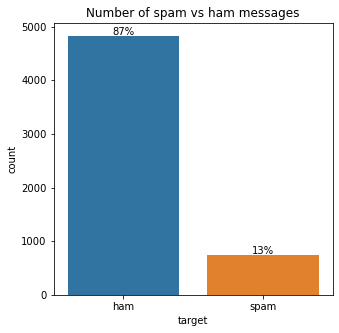

In [24]:
total = len(data)
plt.figure(figsize = (5, 5))
plt.title("Number of spam vs ham messages")
ax = sns.countplot(x = 'target', data = data)
for p in ax.patches:
    percentage = '{0:.0f}%'.format(p.get_height() / total * 100)
    x = p.get_x() + p.get_width() / 2
    y = p.get_height() + 20
    ax.annotate(percentage, (x, y), ha = 'center')
plt.show()

In [25]:
ax.figure.savefig("DATA DISTRUBUTION.png")

In [26]:
data.groupby("target").describe()

text                                                               
       count unique                                                top freq
target                                                                     
ham     4825   4516                             Sorry, I'll call later   30
spam     747    653  Please call our customer service representativ...    4

In [27]:
import string
print(string.punctuation)

!"#$%&'()*+,-./:;<=>?@[\]^_`{|}~


In [28]:
'''
df=data.copy()
df['body_len'] = df.v2.apply(lambda x: len(x) - x.count(" "))

# punct%
def count_punct(text):
    count = sum([1 for char in text if char in string.punctuation])
    return round(count/(len(text) - text.count(" ")), 3) * 100
df['punct%'] = df.v2.apply(lambda x: count_punct(x))''
#df.head(50)
'''

'\ndf=data.copy()\ndf[\'body_len\'] = df.v2.apply(lambda x: len(x) - x.count(" "))\n\n# punct%\ndef count_punct(text):\n    count = sum([1 for char in text if char in string.punctuation])\n    return round(count/(len(text) - text.count(" ")), 3) * 100\ndf[\'punct%\'] = df.v2.apply(lambda x: count_punct(x))\'\'\n#df.head(50)\n'

In [29]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\deekshitha\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [30]:
import nltk
from nltk.stem import PorterStemmer
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords

In [31]:
stemmer = PorterStemmer()
lemmatizer=WordNetLemmatizer()

In [32]:
#pip install contractions
import contractions

In [33]:
def preprocessing(df):
      sms = contractions.fix(df) # converting shortened words to original (Eg:"I'm" to "I am")
      sms = sms.lower() # lower casing the sms
      sms = re.sub(r'https?://S+|www.S+', "", sms).strip() #removing url
      sms = re.sub("[^a-z ]", "", sms) # removing symbols and numbes
      sms = sms.split() #splitting
      # lemmatization and stopword removal
      sms = [lemmatizer.lemmatize(word) for word in sms if not word in set(stopwords.words("english"))]
      sms = " ".join(sms)
      return sms

In [34]:
'''import re
corpus = []
for i in range(len(data)):
    text = re.sub("[^a-zA-Z0-9]"," ",data["text"][i])
    text = text.lower()
    text = text.split()
    text = [stemmer.stem(word) for word in text if not word in set(stopwords.words('english'))]
    text = " ".join(text)
    corpus.append(text)
'''

'import re\ncorpus = []\nfor i in range(len(data)):\n    text = re.sub("[^a-zA-Z0-9]"," ",data["text"][i])\n    text = text.lower()\n    text = text.split()\n    text = [stemmer.stem(word) for word in text if not word in set(stopwords.words(\'english\'))]\n    text = " ".join(text)\n    corpus.append(text)\n'

In [35]:
#print(corpus)

In [36]:
#data['text']=corpus

In [37]:
data.head(3)

,target,text
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...


In [38]:
from sklearn.preprocessing import LabelEncoder
le=LabelEncoder()
data['target']=le.fit_transform(data['target'])

y=data['target']

In [39]:
tfidf=TfidfVectorizer()

In [40]:
X= tfidf.fit_transform(data['text'].apply(preprocessing))

In [41]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.20, random_state = 0)

In [42]:
model = training_basic_classifier(X_train,y_train)

In [43]:
y_pred = predict_on_test_data(model,X_test)

In [44]:
y_pred_prob = predict_prob_on_test_data(model,X_test) #model.predict_proba(X_test)

In [45]:
y_pred

array([0, 0, 0, ..., 0, 0, 0])

In [46]:
y_pred_prob

array([[9.99250916e-01, 7.49083780e-04],
       [9.00631208e-01, 9.93687916e-02],
       [9.56346846e-01, 4.36531537e-02],
       ...,
       [9.80275558e-01, 1.97244423e-02],
       [9.91893784e-01, 8.10621624e-03],
       [9.62769365e-01, 3.72306346e-02]])

In [47]:
run_metrics = get_metrics(y_test, y_pred)

In [48]:
print(run_metrics)

{'accuracy': 0.96, 'precision': 1.0, 'recall': 0.72}


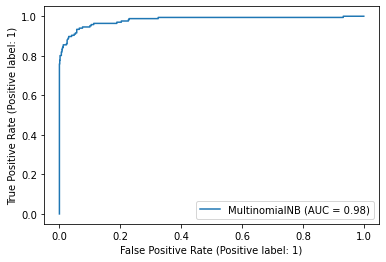

In [49]:
create_roc_auc_plot(model, X_test, y_test)

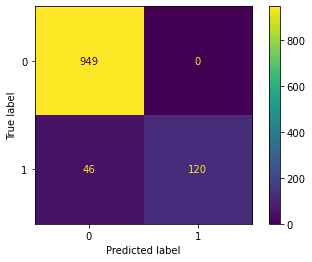

In [50]:
create_confusion_matrix_plot(model, X_test, y_test)

In [51]:
'''
from sklearn.feature_extraction.text import CountVectorizer
cv = CountVectorizer()
X = cv.fit_transform(corpus).toarray()
'''

'\nfrom sklearn.feature_extraction.text import CountVectorizer\ncv = CountVectorizer()\nX = cv.fit_transform(corpus).toarray()\n'

In [52]:
def create_experiment(run_name, run_metrics,model, confusion_matrix_path = None,roc_auc_plot_path = None,plots=None, run_params=None):   
    
    with mlflow.start_run(run_name = "navie_bayes"):
        
        if not run_params == None:
            for param in run_params:
                mlflow.log_param(param, run_params[param])
            
        for metric in run_metrics:
            mlflow.log_metric(metric, run_metrics[metric])
        
        mlflow.sklearn.log_model(model, "model")
        
        if not confusion_matrix_path == None:
            mlflow.log_artifact(confusion_matrix_path, 'confusion_matrix')
            
        if not roc_auc_plot_path == None:
            mlflow.log_artifact(roc_auc_plot_path, "roc_auc_plot")
        if not plots == None:
            mlflow.log_artifact(plots, 'plots')
        
        #mlflow.set_tag("tag1", "navie bayes")
        #mlflow.set_tags({"tag2":"navie bayes Search CV", "tag3":"Production"})
            
    #print('Run - %s is logged to Experiment - %s' %(run_name, experiment_name))

In [53]:
run_name="navie_bayes"
run_metrics = get_metrics(y_test, y_pred)
print(run_metrics)

{'accuracy': 0.96, 'precision': 1.0, 'recall': 0.72}


In [54]:
create_experiment(run_name,run_metrics,model,'confusion_matrix.png', 'roc_auc_curve.png','DATA DISTRUBUTION.png')

In [55]:
import pickle
pickle.dump(model, open("navie_bayes_model.pickel", "wb"))